In [1]:
import os

DIR = "data/fungi_train_val"
filelist = []

for cat in os.listdir(DIR):
    for img in os.listdir(DIR + "/" + cat):
        filelist.append({
            'category': cat[cat.index('_')+1:].replace('_', ' '),
            'filename': img, 
            'path': DIR + "/" + cat + "/" + img, 
            'training': 1})
        
print("Categories:", len(os.listdir(DIR)))
print("Elements:", len(filelist))

Categories: 1394
Elements: 89760


In [2]:
import random

training_size = 0.9
val_set_indexes = []

while len(val_set_indexes) <= int(len(filelist)*(1-training_size)):
    rand = random.randint(0, len(filelist)-1)
    if rand not in val_set_indexes:
        val_set_indexes.append(rand)

for i in range(len(filelist)):
    if i in val_set_indexes:
        filelist[i]['training'] = 0
    else:
        filelist[i]['training'] = 1
        
training_set = list(filter(lambda x: x['training'] == 1, filelist))
validation_set = list(filter(lambda x: x['training'] == 0, filelist))

print("Training set:", len(training_set))
print("Validation set:", len(validation_set))

Training set: 80784
Validation set: 8976


In [3]:
import json

with open('data/train.json') as f:
  data = json.load(f)

{'category': 'Tricholoma sciodes', 'filename': 'MAV2017-9217767_S1Sr16PsZ.JPG', 'path': 'data/fungi_train_val/21144_Tricholoma_sciodes/MAV2017-9217767_S1Sr16PsZ.JPG', 'training': 1}


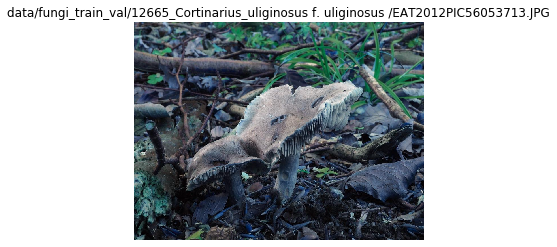

In [4]:
import cv2 
import matplotlib.pyplot as plt

choosen = random.randint(0, len(filelist)-1)
print(filelist[choosen])

img = cv2.imread(filelist[choosen]['path'])  
plt.title(filelist[0]['path'])
plt.grid(False)
plt.axis('off')
plt.imshow(img)
plt.show()

In [5]:
image_id = list(filter(
    lambda x: x['file_name'].replace("images/", "data/fungi_train_val/") == filelist[choosen]['path'],
    data['images']))[0]['id']
category_id = list(filter(lambda x: x['image_id'] == image_id, data['annotations']))[0]['category_id']
category = list(filter(lambda x: x['id'] == category_id, data['categories']))
print(filelist[choosen]['path'], category)

data/fungi_train_val/21144_Tricholoma_sciodes/MAV2017-9217767_S1Sr16PsZ.JPG [{'id': 1104, 'name': 'Tricholoma sciodes', 'supercategory': 'Tricholoma'}]


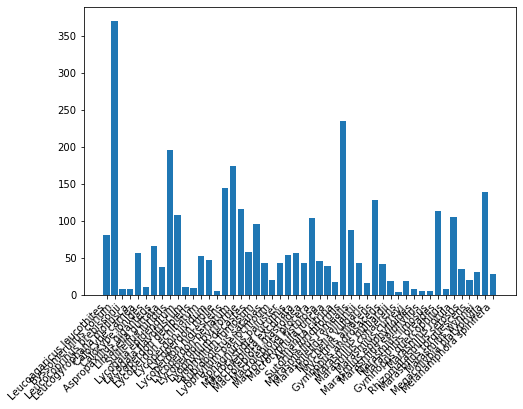

In [6]:
from collections import Counter

occ = Counter(list(map(lambda x: x['category_id'], data['annotations'])))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = list(map(lambda x: x['name'], data['categories']))[:50]
y = [occ[el] for el in occ][:50]
ax.bar(x, y)
ax.set_xticklabels(x, rotation=45, ha='right')
plt.show()

In [7]:
import pandas as pd

for i in range(len(data['images'])):
    data['images'][i]['file_name'] = data['images'][i]['file_name'].replace("images/", "data/fungi_train_val/")

df_images = pd.DataFrame(data['images'])
df_categories = pd.DataFrame(data['categories'])
df_annotations = pd.DataFrame(data['annotations'])
df_images.head()

df = pd.merge(df_images, df_annotations, left_on='id', right_on='image_id')
df = pd.merge(df, df_categories, left_on='category_id', right_on='id')
df.head()

,id_x,file_name,width,license,rights_holder,height,id_y,category_id,image_id,id,name,supercategory
0,21942,data/fungi_train_val/16390_Leucoagaricus_leuco...,1300,1,Ole B. Lyshede,732,43829,650,21942,650,Leucoagaricus leucothites,Leucoagaricus
1,21943,data/fungi_train_val/16390_Leucoagaricus_leuco...,1400,1,Ole B. Lyshede,788,44039,650,21943,650,Leucoagaricus leucothites,Leucoagaricus
2,21944,data/fungi_train_val/16390_Leucoagaricus_leuco...,1400,1,Ole B. Lyshede,788,44255,650,21944,650,Leucoagaricus leucothites,Leucoagaricus
3,22210,data/fungi_train_val/16390_Leucoagaricus_leuco...,567,1,Frank Desting,425,44614,650,22210,650,Leucoagaricus leucothites,Leucoagaricus
4,24812,data/fungi_train_val/16390_Leucoagaricus_leuco...,770,1,Frank Desting,577,45510,650,24812,650,Leucoagaricus leucothites,Leucoagaricus


In [8]:
df = pd.DataFrame(filelist)
df_training = df.loc[df['training'] == 1]
df_validation = df.loc[df['training'] == 0]

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DIR = os.getcwd()
training_datagen = ImageDataGenerator(rescale=1./255)

train_generator = training_datagen.flow_from_dataframe(
    df_training[:900],
    DIR,
    'path',
    'category',
    target_size=(100, 100),
    class_mode='categorical'
)

Found 900 validated image filenames belonging to 12 classes.


In [40]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    df_validation[:115],
    DIR,
    'path',
    'category',
    target_size=(100, 100),
    class_mode='categorical'
)

Found 115 validated image filenames belonging to 12 classes.


In [11]:
classes = [0 for i in range(max(validation_generator.classes)+1)]

for i in range(len(validation_generator.filenames)):
    cat = df.loc[df['path'] == validation_generator.filenames[i]]['category'].values[0]
    classes[validation_generator.classes[i]] = cat

print(classes)

['Amanita citrina var. citrina', 'Cortinarius alboviolaceus', 'Cortinarius uliginosus f. uliginosus ', 'Fomes fomentarius', 'Gyrodon lividus', 'Lachnum impudicum', 'Leotia lubrica', 'Mycena aetites', 'Mycena polygramma', 'Peniophorella praetermissa', 'Russula fellea', 'Schizophyllum commune']


In [43]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 98, 98, 64)        1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 47, 47, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)        

In [ ]:
model.load_weights('model.h5')

In [46]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [47]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(train_generator, epochs=100,
            validation_data = validation_generator,
            verbose=1, callbacks=[es])

model.save_weights('model.h5')

Epoch 1/100
29/29 [==============================] - 19s 647ms/step - loss: 2.3175 - accuracy: 0.2600 - val_loss: 2.1352 - val_accuracy: 0.3043
Epoch 2/100
29/29 [==============================] - 28s 958ms/step - loss: 2.1393 - accuracy: 0.3067 - val_loss: 1.9996 - val_accuracy: 0.3217
Epoch 3/100
29/29 [==============================] - 18s 620ms/step - loss: 2.0533 - accuracy: 0.3067 - val_loss: 1.9305 - val_accuracy: 0.3130
Epoch 4/100
29/29 [==============================] - 18s 618ms/step - loss: 1.9537 - accuracy: 0.3778 - val_loss: 1.9464 - val_accuracy: 0.3826
Epoch 5/100
29/29 [==============================] - 18s 628ms/step - loss: 1.9074 - accuracy: 0.3678 - val_loss: 1.8278 - val_accuracy: 0.3652
Epoch 6/100
29/29 [==============================] - 18s 625ms/step - loss: 1.8103 - accuracy: 0.3856 - val_loss: 1.8343 - val_accuracy: 0.4261
Epoch 7/100
29/29 [==============================] - 18s 636ms/step - loss: 1.7445 - accuracy: 0.4289 - val_loss: 1.7375 - val_accuracy:

OSError: Unable to create file (unable to open file: name = 'model/model.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

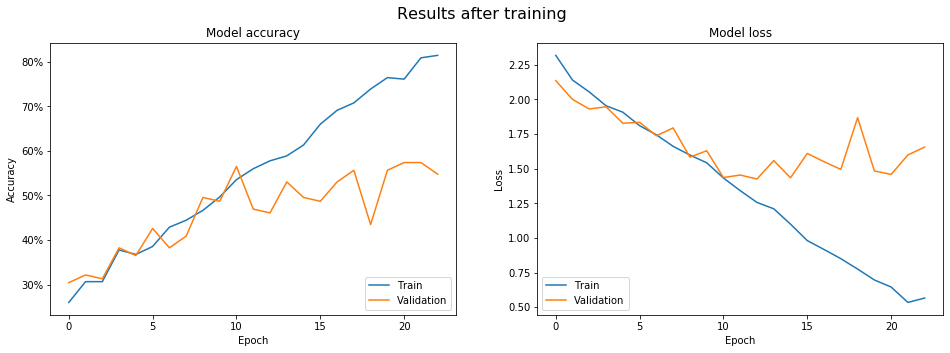

In [48]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

fig, axes = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('Results after training', fontsize=16)

# summarize history for accuracy
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='lower right')

# summarize history for loss
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='lower left')

plt.show()

In [49]:
val_loss, val_acc = model.evaluate(validation_generator)

4/4 [==============================] - 1s 147ms/step - loss: 1.6559 - accuracy: 0.5478


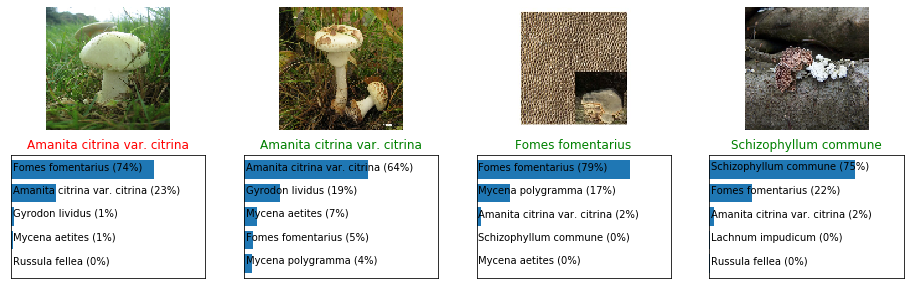

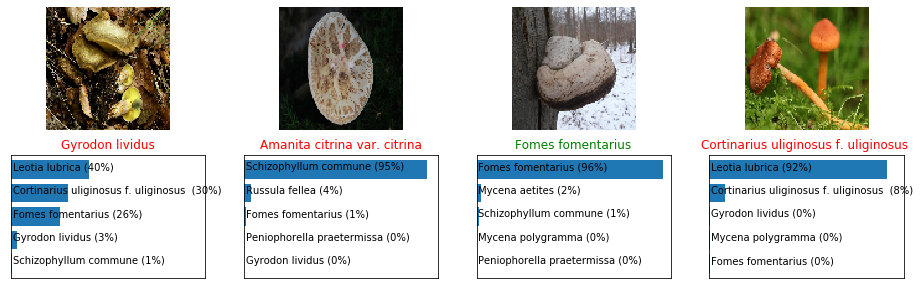

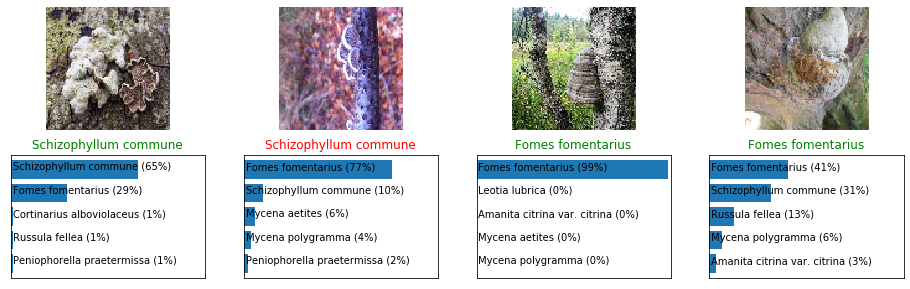

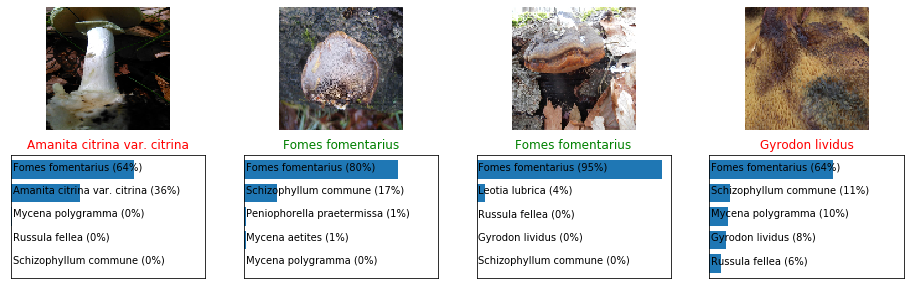

In [133]:
import matplotlib.image as mpimg
import numpy as np

iters = 0
    
for i, batch in enumerate(validation_generator):
    if iters > 3:
        break
    
    batch_images, batch_labels = batch
    
    for j in range(len(batch_images)):
        if iters > 3:
            break
            
        n_cols = 4
            
        fig, axes = plt.subplots(2, n_cols, figsize=(16,5))
        
        for k in range(n_cols):
            prediction = model.predict(np.array([batch_images[j*n_cols+k]]))
            res = [{'label': classes[h], 'val': prediction[0][h]} for h in range(len(classes))]
            res.sort(key=lambda x: x['val'], reverse=True)
            res = res[0:5]
            axes[0][k].imshow(batch_images[j*n_cols+k])
            axes[0][k].grid(False)
            axes[0][k].axis('off')
            title_color = 'green'
            if np.argmax(batch_labels[j*n_cols+k]) != np.argmax(prediction[0]):
                title_color = 'red'
            axes[1][k].set_title(classes[np.argmax(batch_labels[j*n_cols+k])], color=title_color)
            axes[1][k].barh([x['label'] for x in res], [x['val'] for x in res])
            axes[1][k].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
            axes[1][k].set_xlim(0, 1)
            axes[1][k].invert_yaxis()
            axes[1][k].set_xticks([])
            axes[1][k].set_yticks([])
            for h, v in enumerate(res):
                axes[1][k].text(0.01, h, '{} ({:.0%})'.format(v['label'], v['val']))

        plt.show()
        
        iters += 1